In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn import metrics
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download dataset
! wget https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar -P ../data/

# Extract dataset using unrar
!pip install unrar
!unrar e ../data/sensors-activity-recognition-dataset-shoaib.rar ../data/

--2022-05-05 04:25:20--  https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar
Resolving www.utwente.nl (www.utwente.nl)... 130.89.3.249, 2001:67c:2564:a102::1:1
Connecting to www.utwente.nl (www.utwente.nl)|130.89.3.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100080442 (95M) [application/x-rar-compressed]
Saving to: ‘../data/sensors-activity-recognition-dataset-shoaib.rar’

sensors-activity-re 100%[===================>]  95.44M  14.2MB/s    in 8.2s    

2022-05-05 04:25:29 (11.6 MB/s) - ‘../data/sensors-activity-recognition-dataset-shoaib.rar’ saved [100080442/100080442]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from ../data/sensors-activity-recognition-dataset-shoaib.rar

Extracting  ../data/Participant_1.csv                                      0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10%  OK 
Extracting  ../data/Particip

In [ ]:
df = pd.DataFrame()
for i in range(10):
    df_tmp = pd.read_csv('../data/Participant_' + str(i+1) + '.csv', header=1)
    df = pd.concat([df, df_tmp])

df.head()

,time_stamp,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,...,Lx.4,Ly.4,Lz.4,Gx.4,Gy.4,Gz.4,Mx.4,My.4,Mz.4,Unnamed: 69
0,1.390000e+12,-1.81150,-14.873,-1.34840,-1.26910,-5.1057,-0.66445,-0.53206,-3.18690,0.23976,...,-5.3574,-0.95749,0.318860,0.52565,-0.18815,0.285880,-22.20,6.48,4.56,walking
1,1.390000e+12,0.24517,-14.070,-0.84446,0.70147,-4.2969,-0.17199,-0.25229,-1.79660,0.40745,...,-4.5352,-0.67629,0.081656,0.43616,0.16371,0.198230,-21.90,7.14,5.34,walking
2,1.390000e+12,-0.57205,-14.628,-1.75700,-0.21760,-4.8531,-1.05650,-1.04920,0.29138,0.29230,...,-4.0408,-0.55974,-0.523690,0.32284,0.43127,0.211970,-21.60,7.50,5.64,walking
3,1.390000e+12,-0.69464,-12.939,-3.09180,-0.32273,-3.1786,-2.21970,-2.37200,1.00820,0.34972,...,-3.5908,0.15795,-1.880200,0.20403,0.72846,0.164930,-21.12,8.40,6.12,walking
4,1.390000e+12,0.87170,-12.000,-1.56630,1.13740,-2.2390,-0.65476,-2.79010,0.65485,0.22724,...,-1.9450,0.85796,-2.995300,0.09896,0.94379,0.064752,-20.94,8.70,6.30,walking


In [ ]:
df.shape

(630000, 70)

In [ ]:
split_point = int(len(df) * 0.8)
train_data = df.iloc[:split_point, :]
test_data = df.iloc[split_point:, :]

print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))

Number of train samples:  504000
Number of test samples:  126000


In [ ]:
def concat(data):
    
    # Select left pocket data
    left_pocket = data.iloc[:,1:10]
    
    #Square root of sum of squares of accelerometer, linear acceleration and gyroscope data
    left_pocket["MA"] = np.sqrt(np.square(left_pocket['Ax']) + np.square(left_pocket['Ay']) + np.square(left_pocket['Az']))
    left_pocket["ML"] = np.sqrt(np.square(left_pocket['Lx']) + np.square(left_pocket['Ly']) + np.square(left_pocket['Lz']))
    left_pocket["MG"] = np.sqrt(np.square(left_pocket['Gx']) + np.square(left_pocket['Gy']) + np.square(left_pocket['Gz']))
    

    # Select right pocket data
    right_pocket = data.iloc[:,15:24]
    right_pocket.columns=['Ax', 'Ay', 'Az', 'Lx', 'Ly', 'Lz', 'Gx', 'Gy', 'Gz']
    
    #Square root of sum of squares of accelerometer, linear acceleration and gyroscope data
    right_pocket["MA"] = np.sqrt(np.square(right_pocket['Ax']) + np.square(right_pocket['Ay']) + np.square(right_pocket['Az']))
    right_pocket["ML"] = np.sqrt(np.square(right_pocket['Lx']) + np.square(right_pocket['Ly']) + np.square(right_pocket['Lz']))
    right_pocket["MG"] = np.sqrt(np.square(right_pocket['Gx']) + np.square(right_pocket['Gy']) + np.square(right_pocket['Gz']))

    
    # Extract labels 
    labels = data.iloc[:, 69] 
    labels = labels.to_frame()
    labels.columns=['Activity_Label']
    labels = pd.concat([labels]*2, ignore_index=True)
    #replace typo 'upsatirs' with upstairs! 
    labels.loc[(labels['Activity_Label'] == 'upsatirs')] = 'upstairs'
    
    #Concatenate left pocket and right pocket data into a single data frame (we only use left pocket and right pocket data)
    frames = [left_pocket, right_pocket]
    df = pd.concat(frames)
   
    return df, labels

# Generate input data and labels
train_X, train_y = concat(train_data)
test_X, test_y = concat(test_data)
train_X.head()

,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,MA,ML,MG
0,-1.81150,-14.873,-1.34840,-1.26910,-5.1057,-0.66445,-0.53206,-3.18690,0.23976,15.043465,5.302856,3.239893
1,0.24517,-14.070,-0.84446,0.70147,-4.2969,-0.17199,-0.25229,-1.79660,0.40745,14.097451,4.357177,1.859419
2,-0.57205,-14.628,-1.75700,-0.21760,-4.8531,-1.05650,-1.04920,0.29138,0.29230,14.744242,4.971531,1.127458
3,-0.69464,-12.939,-3.09180,-0.32273,-3.1786,-2.21970,-2.37200,1.00820,0.34972,13.321392,3.890337,2.600991
4,0.87170,-12.000,-1.56630,1.13740,-2.2390,-0.65476,-2.79010,0.65485,0.22724,12.133143,2.595286,2.874913


In [ ]:
train_y.head()

,Activity_Label
0,walking
1,walking
2,walking
3,walking
4,walking


In [ ]:
N_TIME_STEPS = 100 #sliding window length
STEP = 50 #Sliding window step size
N_FEATURES = 12 

def generate_sequence(x, y, n_time_steps, step):
    
    segments = []
    labels = []
    for i in range(0, len(x) - n_time_steps, step):
        ax = x['Ax'].values[i: i + n_time_steps]
        ay = x['Ay'].values[i: i + n_time_steps]
        az = x['Az'].values[i: i + n_time_steps]

        lx = x['Lx'].values[i: i + n_time_steps]
        ly = x['Ly'].values[i: i + n_time_steps]
        lz = x['Lz'].values[i: i + n_time_steps]
        
        gx = x['Gx'].values[i: i + n_time_steps]
        gy = x['Gy'].values[i: i + n_time_steps]
        gz = x['Gz'].values[i: i + n_time_steps]

        MA = x['MA'].values[i: i + n_time_steps]
        ML = x['ML'].values[i: i + n_time_steps]
        MG = x['MG'].values[i: i + n_time_steps]
       
        label = stats.mode(y['Activity_Label'][i: i + n_time_steps])[0][0]
        segments.append([ax, ay, az, lx, ly, lz, gx, gy, gz, MA, ML, MG])
        labels.append(label)
        
    return segments, labels

train_X, train_y = generate_sequence(train_X, train_y, N_TIME_STEPS, STEP)
test_X, test_y = generate_sequence(test_X, test_y, N_TIME_STEPS, STEP)

In [ ]:
# reshape input segments and one-hot encode labels
def reshape_segments(x, y, n_time_steps, n_features):
    
    x_reshaped = np.asarray(x, dtype= np.float32).reshape(-1, n_time_steps, n_features)
    y_reshaped = np.asarray(pd.get_dummies(y), dtype = np.float32)
    return x_reshaped, y_reshaped

X_train, y_train = reshape_segments(train_X, train_y, N_TIME_STEPS, N_FEATURES)
X_test, y_test = reshape_segments(test_X, test_y, N_TIME_STEPS, N_FEATURES)

In [ ]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from tensorflow.keras import optimizers

N_CLASSES = 7
N_HIDDEN_UNITS = 32
L2 = 0.000001

model = Sequential([
    LSTM(N_HIDDEN_UNITS, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
         kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
         bias_regularizer=l2(L2), name="LSTM_1"),
    Flatten(name='Flatten'),
    Dense(N_HIDDEN_UNITS, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_1"),
    Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_2")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 100, 32)           5760      
                                                                 
 Flatten (Flatten)           (None, 3200)              0         
                                                                 
 Dense_1 (Dense)             (None, 32)                102432    
                                                                 
 Dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 108,423
Trainable params: 108,423
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
BATCH_SIZE = 1024
N_EPOCHS = 40

model.fit(X_train, y_train,
          batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

Epoch 1/40
20/20 [==============================] - 12s 83ms/step - loss: 1.5398 - accuracy: 0.4960 - val_loss: 1.2894 - val_accuracy: 0.6334
Epoch 2/40
20/20 [==============================] - 0s 24ms/step - loss: 1.0998 - accuracy: 0.7532 - val_loss: 0.9864 - val_accuracy: 0.7692
Epoch 3/40
20/20 [==============================] - 0s 21ms/step - loss: 0.8305 - accuracy: 0.8522 - val_loss: 0.7641 - val_accuracy: 0.8535
Epoch 4/40
20/20 [==============================] - 0s 24ms/step - loss: 0.6239 - accuracy: 0.9058 - val_loss: 0.5914 - val_accuracy: 0.9043
Epoch 5/40
20/20 [==============================] - 0s 21ms/step - loss: 0.4711 - accuracy: 0.9382 - val_loss: 0.4622 - val_accuracy: 0.9369
Epoch 6/40
20/20 [==============================] - 0s 22ms/step - loss: 0.3624 - accuracy: 0.9463 - val_loss: 0.3672 - val_accuracy: 0.9436
Epoch 7/40
20/20 [==============================] - 0s 22ms/step - loss: 0.2850 - accuracy: 0.9524 - val_loss: 0.3018 - val_accuracy: 0.9470
Epoch 8/40
2

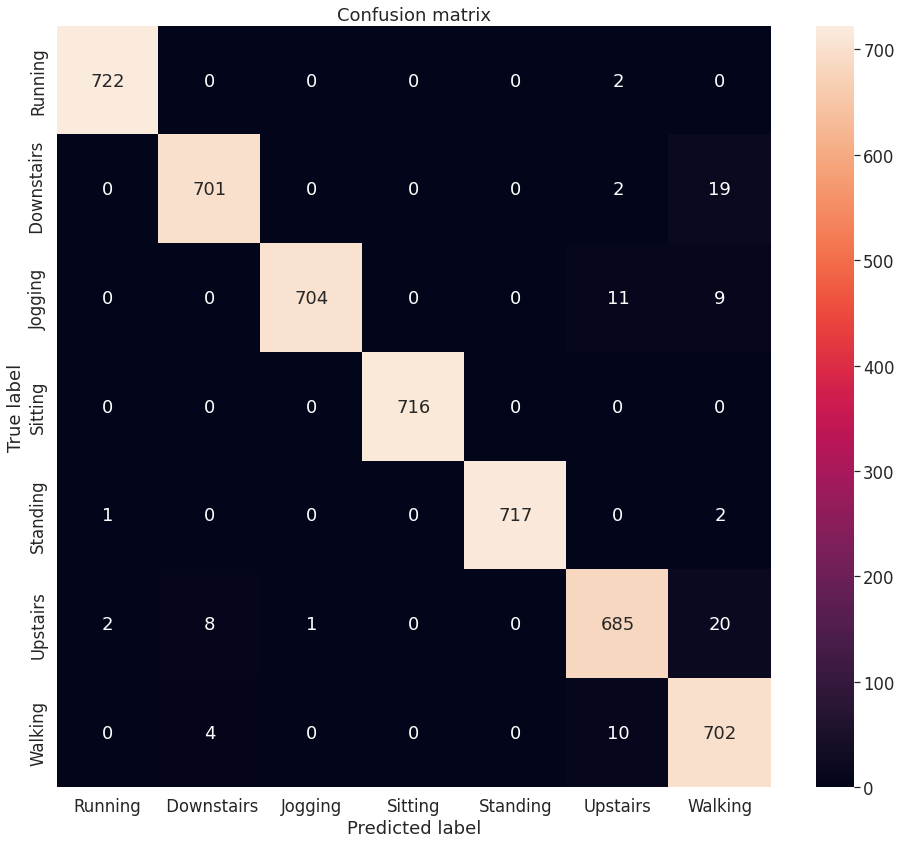

In [ ]:
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

LABELS = ['Running' ,' Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

plt.figure(figsize=(16, 14))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [ ]:
from keras import backend
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

input_node_names= ["LSTM_1_input"]
output_node_name = "Dense_2/Softmax"
MODEL_NAME = "HAR"

tf.train.write_graph(backend.get_session().graph_def, 'models', \MODEL_NAME + '_graph.pbtxt')
saver = tf.train.Saver()
saver.save(backend.get_session(), 'models/' + MODEL_NAME + '.chkp')

freeze_graph.freeze_graph('models/' + MODEL_NAME + '_graph.pbtxt', None, \False, 'models/' + MODEL_NAME + '.chkp', output_node_name, \"save/restore_all", "save/Const:0", \'models/frozen_' + MODEL_NAME + '.pb', True, "")